[Check out this article](https://theathletic.com/3346644/2022/06/07/premier-league-pass-networks/) for an engaging overview on passing networks in the Premier League. 

This notebook is for running course code to explore the Statsbomb API.

### Import libraries

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
pd.options.display.max_info_columns = 100

### Look for Barcelona matches

According to the Statsbomb Github documentation:
1. Competition and seasons stored in competitions.json.
2. Matches for each competition and season, stored in matches. Each folder within is named for a competition ID, each file is named for a season ID within that competition.
3. Events and lineups for each match, stored in events and lineups respectively. Each file is named for a match ID.
4. StatsBomb 360 data for selected matches, stored in three-sixty. Each file is named for a match ID.

In [105]:
df_competition = parser.competition()
df_competition.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2022-08-14T16:57:15.866765,2021-06-13T16:17:31.694,None,2022-08-14T16:57:15.866765
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
3,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,26,Europe,Champions League,male,False,False,2014/2015,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [106]:
df_competition['competition_name'].unique()

array(['Champions League', "FA Women's Super League", 'FIFA World Cup',
       'Indian Super league', 'La Liga', 'NWSL', 'Premier League',
       'UEFA Euro', "UEFA Women's Euro", "Women's World Cup"],
      dtype=object)

In [107]:
df_competition['season_name'].unique()

array(['2018/2019', '2017/2018', '2016/2017', '2015/2016', '2014/2015',
       '2013/2014', '2012/2013', '2011/2012', '2010/2011', '2009/2010',
       '2008/2009', '2006/2007', '2004/2005', '2003/2004', '1999/2000',
       '2020/2021', '2019/2020', '2018', '2021/2022', '2007/2008',
       '2005/2006', '2020', '2022', '2019'], dtype=object)

#### Create a query to filter to a specific Competition and Year (Season)

In [108]:
df_competition.query('competition_name == "Champions League"and season_name == "2008/2009"', inplace=True)
df_competition.head()


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
10,16,41,Europe,Champions League,male,False,False,2008/2009,2021-11-07T14:20:01.699993,2021-06-13T16:17:31.694,None,2021-11-07T14:20:01.699993


#### Use the competition ID and season ID to inspect more data

In [110]:
df_match = parser.match(competition_id=16, season_id=41)
# Set the verbose argument on info to get a full summary of the data
df_match.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         1 non-null      int64         
 1   match_date                       1 non-null      datetime64[ns]
 2   kick_off                         1 non-null      datetime64[ns]
 3   home_score                       1 non-null      int64         
 4   away_score                       1 non-null      int64         
 5   match_status                     1 non-null      object        
 6   match_status_360                 1 non-null      object        
 7   last_updated                     1 non-null      datetime64[ns]
 8   last_updated_360                 1 non-null      datetime64[ns]
 9   match_week                       1 non-null      int64         
 10  competition_id                   1 non-null      int64         
 1

In [112]:
print(df_match['home_team_name'].values)
print(df_match['away_team_name'].values)

['Barcelona']
['Manchester United']


#### Use the match_id

In [113]:
df_match.head()

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,3750201,2009-05-27,2009-05-27 20:45:00,2,0,available,scheduled,2021-11-07 14:20:01.699993,2021-06-13 16:17:31.694,1,...,26,Final,381,Estadio Olímpico,112,Italy,705,Massimo Busacca,221,Switzerland


### Parse the data using the match_id

In [85]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3750201)

In [114]:
#check for index of first sub
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Barcelona"].iloc[0]["index"]
#make df with successfull passes by Barcelona until the first substitution
mask_barcelona = (df.type_name == 'Pass') & (df.team_name == "Barcelona") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
#taking necessary columns
df_pass = df.loc[mask_barcelona, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [115]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [116]:
#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

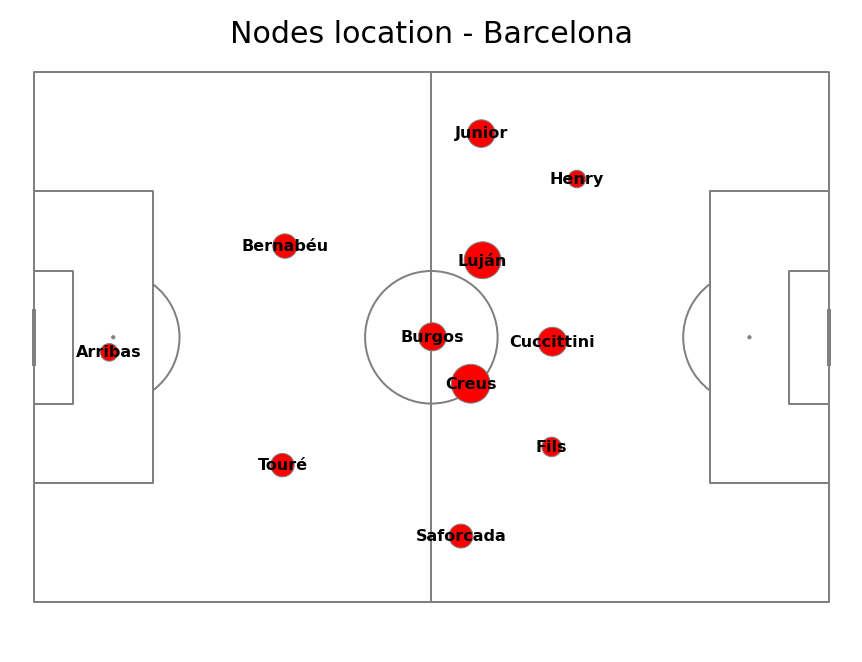

In [127]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - Barcelona", fontsize = 30)
plt.show()

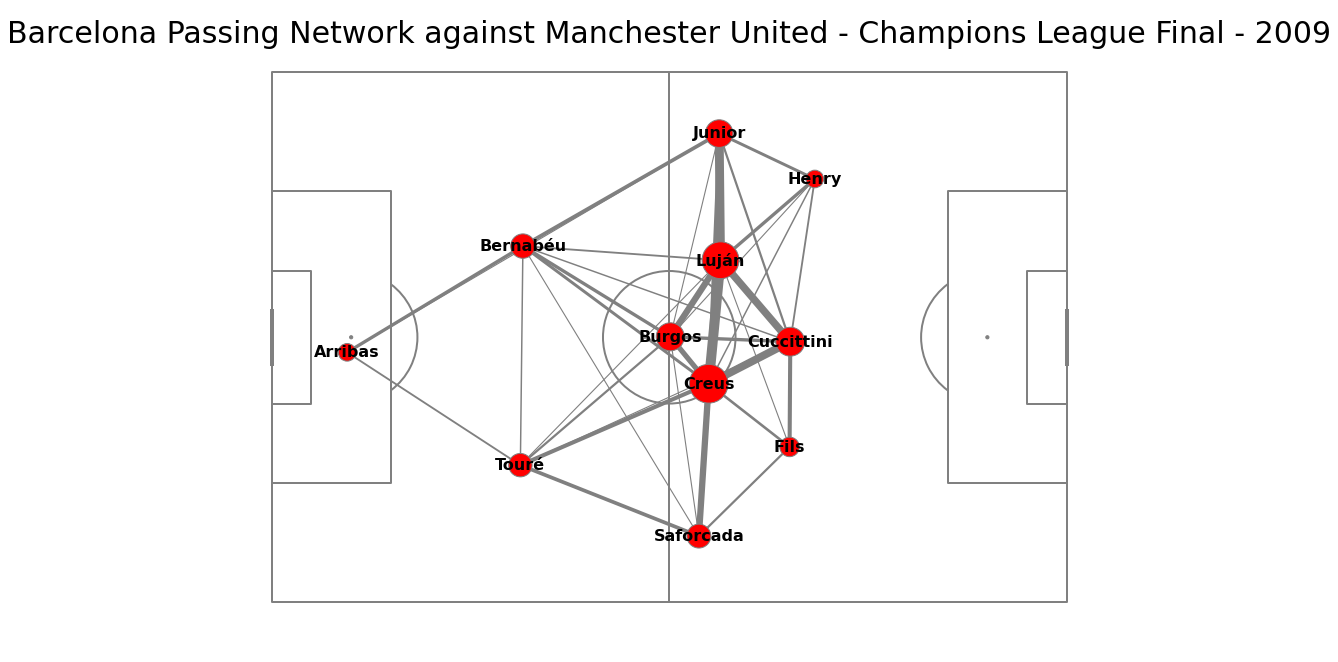

In [128]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="grey", ax = ax["pitch"])

fig.suptitle("Barcelona Passing Network against Manchester United - Champions League Final - 2009", fontsize = 30)
plt.show()

In [129]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max()
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum()
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralization index is ", centralisation_index)

Centralization index is  0.10748502994011976


What is the centrality index?
This paper on [centrality measurements in passing-network analysis of soccer](https://www.scitepress.org/Papers/2019/73775/73775.pdf) says "Centrality is an index of the degree of influence that
any node gives to other nodes in a graph network
(Tsugawa and Ohsaki, 2014). This index makes it
possible to estimate an important individual in an organization. Because soccer places more emphasis on
organizational team play, applying the index would be
appropriate."

In Chapter 7 of Soccermatics, the author gives a clear example of centrality: "Thomas also looked at centrality. Teams that focused their passing on only a few players scored fewer goals than teams that passed the ball more evenly between all members of the team. Here the difference is harder to quantify exactly, but roughly speaking, being decentralised gives a team an 8% advantage in terms of scoring rate."

The author goes on to say, "...from Thomas’s study we would expect the team with the lower measure to be more successful." Sumpter, David. Soccermatics (Bloomsbury Sigma) (p. 124). Bloomsbury Publishing. Kindle Edition.  